In [9]:
import pandas as pd
import re
import glob
import os
from scipy import stats
import numpy as np
from scipy.optimize import minimize 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import newton
from matplotlib.patches import Polygon

In [10]:
colors = {
        "dark_purple": "#5F2E88",
        "purple": "#7E59A2",
        "light_purple": "#A17DB8",
        "pale_purple": "#dfd6e5",
        "dark_orange": "#F38227",
        "orange": "#E39943",
        "light_orange": "#EEBA7F",
        "pale_orange": "#f2d4b6",
        "dark_blue": "#3F60AC",
        "blue": "#7292C7",
        "light_blue": "#A5B3CC",
        "pale_blue": "#dae4f1",
        "dark_red": "#9C372F",
        "red": "#C76A6A",
        "light_red": "#E39C9D",
        "pale_red": "#edcccc",
        "dark_green": "#395A34",
        "green": "#688A2F",
        "light_green": "#B3CD86",
        "pale_green": "#d8e2c3",
        "dark_brown": "#764f2a",
        "brown": "#c2996c",
        "light_brown": "#e1bb96",
        "pale_brown": "#efccaf",
        "black": "#444147",
        "light_grey": "#EFEFEF",
        "light_gray": "#EFEFEF",
        "grey": "#6D6F72",
        "gray": "#6D6F72",
}

In [11]:
d = {'Cys': 'C', 'Asp': 'D', 'Ser': 'S', 'Gln': 'Q', 'Lys': 'K',
     'Ile': 'I', 'Pro': 'P', 'Thr': 'T', 'Phe': 'F', 'Asn': 'N', 
     'Gly': 'G', 'His': 'H', 'Leu': 'L', 'Arg': 'R', 'Trp': 'W', 
     'Ala': 'A', 'Val':'V', 'Glu': 'E', 'Tyr': 'Y', 'Met': 'M'}
d2=dict((v, k) for k, v in d.items())

In [12]:
def truncated_mean(lam):
    mu=(1/lam-np.exp(-lam)*(1+1/lam))/(1-np.exp(-lam))
    return mu
def equation(lam, given_mu):
    return truncated_mean(lam) - given_mu

def truncated_expo_density(x, lmbda):
    return lmbda * np.exp(-lmbda * x) / (1 - np.exp(-lmbda))

def truncated_expo_cdf(x, lmbda):
    return (1 - np.exp(-lmbda * x)) / (1 - np.exp(-lmbda))

In [13]:
dtype_spec = {30: str, 31: str, 36: str}
all_dms=pd.read_csv('../Data/Tsuboyama2023_Dataset2_Dataset3_20230416.csv',dtype=dtype_spec)
pattern = '^[A-Z]\d+[A-Z]$'
all_dms=all_dms[all_dms['mut_type'].str.match(pattern)]
all_dms['mut_type']=all_dms['mut_type'].str.replace(r'\d+', '', regex=True)
all_dms=all_dms[all_dms['ddG_ML']!='-']
all_dms['DMS_score']=pd.to_numeric(all_dms['ddG_ML'])
np.random.seed(0)
all_dms['split']=np.random.choice(['train','test'],size=len(all_dms))
all_dms['fit_rank']=all_dms.groupby(['split','WT_name'])['DMS_score'].rank(pct=True)
all_dms['fit_rank_all']=all_dms.groupby('WT_name')['DMS_score'].rank(pct=True)

In [14]:
all_dms['AA1']=all_dms['mut_type'].str[0]
all_dms['AA2']=all_dms['mut_type'].str[1]

In [15]:
#pre-process data frame
AA_list=['Arg','Lys','Gln','Glu','Asp',
         'Asn','His','Ser','Thr','Ala',
         'Val','Ile','Leu','Met','Pro',
         'Gly','Tyr','Phe','Trp','Cys']
aa_list=[d[a] for a in AA_list]

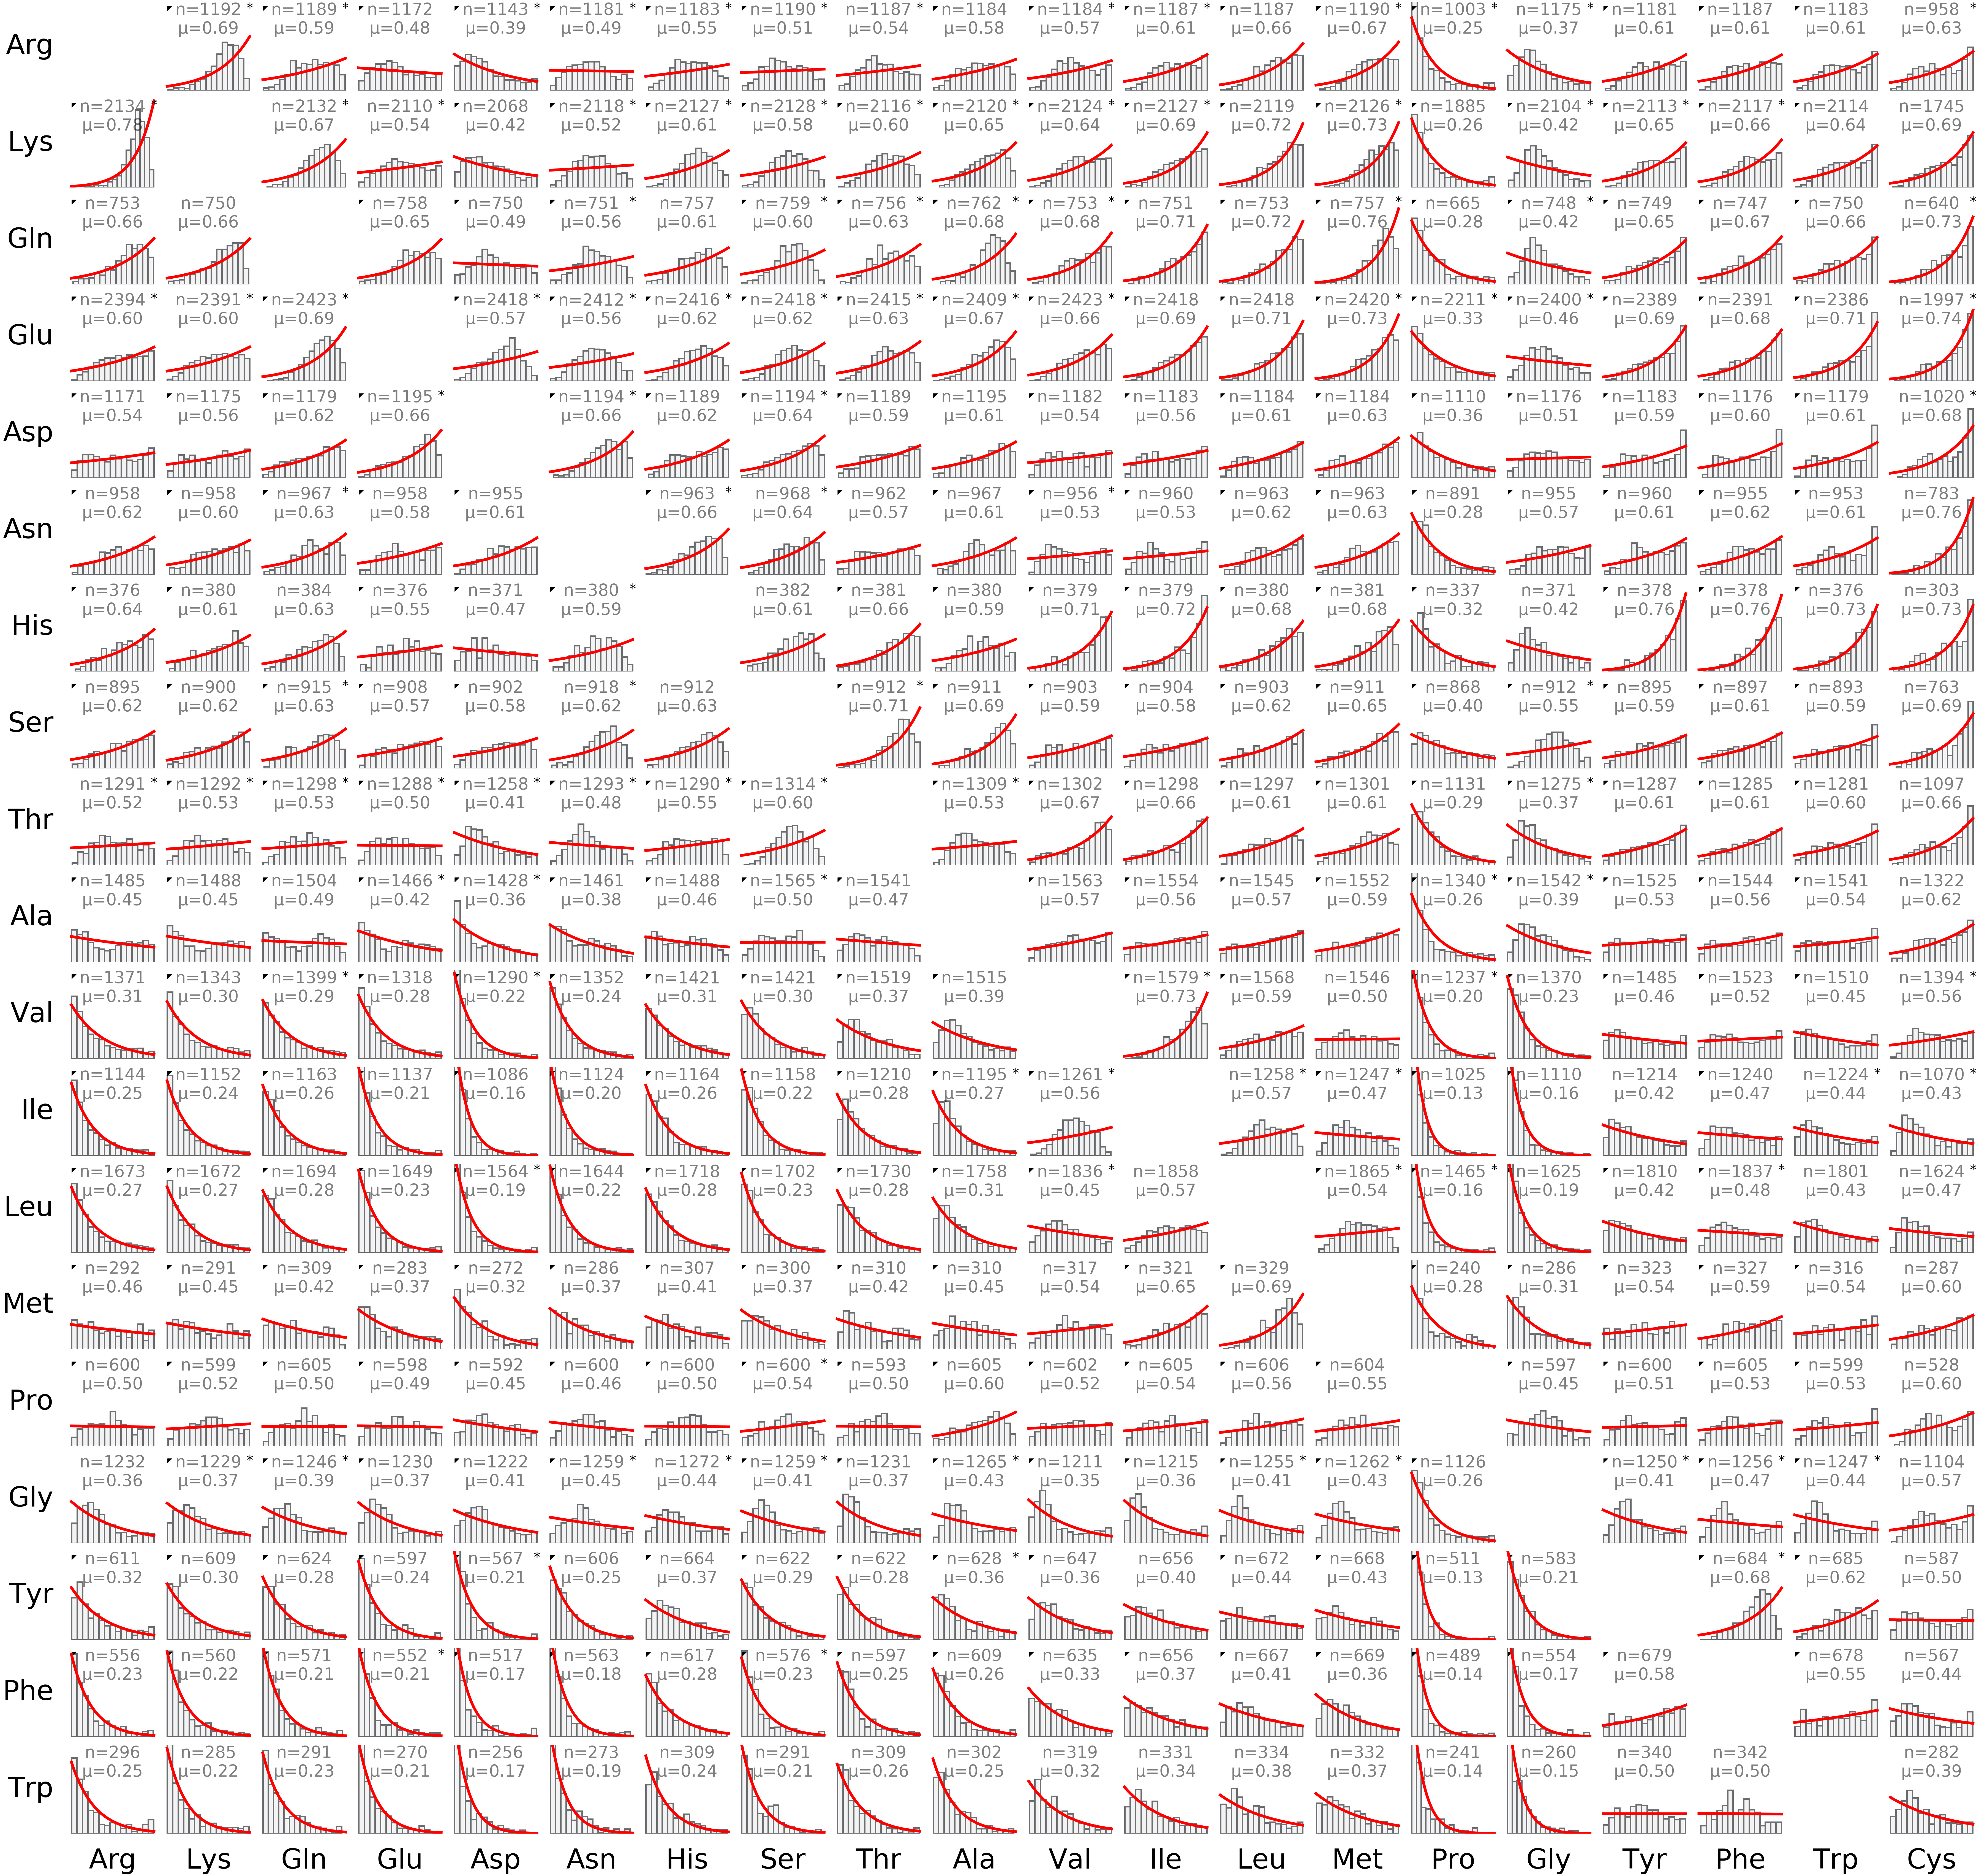

In [16]:
#grid plot,Fig.S4
fig, axes = plt.subplots(19, 20, figsize=(100, 95))
aa_pair=[]
sig=0
sym_sig=0
for i in range(19):
    for j in range(20):
        ax = axes[i, j]
        #ax.set_facecolor(colors['light_gray']) 
        if i!=j:
            data = all_dms[(all_dms['AA1']==aa_list[i])&(all_dms['AA2']==aa_list[j])]
            if i!=18:
                data_reverse=all_dms[(all_dms['AA1']==aa_list[j])&(all_dms['AA2']==aa_list[i])]
                D_sym,p_sym=stats.ks_2samp(data.fit_rank.tolist(),data_reverse.fit_rank.tolist())
            data_train=np.array(data[data['split']=='train'].fit_rank.tolist())
            data_test=np.array(data[data['split']=='test'].fit_rank.tolist())
            given_mu=np.mean(data_train)
            # Extract the lambda parameter that maximizes the likelihood
            lmbda_opt = newton(equation, 1, args=(given_mu,))
            Di,pi=stats.kstest(data_test, truncated_expo_cdf, args=(lmbda_opt,))
            aa_pair.append(aa_list[i]+'-'+aa_list[j])
            np.random.seed(0)
            data_array = np.array(data.fit_rank.tolist())
            sns.histplot(data, x='fit_rank_all', bins=15, stat='density', ax=ax,color=colors['light_gray'],linewidth=5,
                         edgecolor=colors['gray'])
            X = np.linspace(0, 1, 100)
            ax.plot(X, truncated_expo_density(X, lmbda=lmbda_opt), color='red',linewidth=10)
            # Add text inside the panel
            ax.text(0.5, 0.8, f'n={len(data)}\nμ={given_mu:.2f}', 
                    ha='center', va='center', 
                    color=(0, 0, 0, 0.5),
                    fontsize=60, 
                    transform=ax.transAxes)

            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.set_ylim(0,4.5)
            #ax.set_title('n=' + str(len(data)),fontsize=60)
            #ax.set_title('n=' + str(len(data)), fontsize=60, loc='center', y=0.8)
            #if (pi*380)>0.05:
                #ax.set_facecolor(colors['light_gray'])
            if (pi*361)<=0.05:
                x_max = ax.get_xlim()[1]
                y_max = ax.get_ylim()[1]
                offset = 0.01 
                ax.text(x_max - offset, y_max - offset, '*', ha='right', va='top', fontsize=48)
                sig+=1
            if (i!=18) and (p_sym*153<=0.05):
                triangle = Polygon([[0.05, 0.95], [0.1, 0.95], [0.05, 0.9]], closed=True, color='black', transform=ax.transAxes)
                ax.add_patch(triangle)
                sym_sig+=1
        if i==18:
            ax.set_xlabel(AA_list[j],fontsize=100,labelpad=50)
        if j==0:
            ax.set_ylabel(AA_list[i],rotation=0,fontsize=100,labelpad=50, ha='right', va='center')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)


plt.tight_layout()
plt.show()

In [17]:
1-sig/361

0.6925207756232687

In [18]:
1-sym_sig/302

0.0066225165562914245